In [1]:
'''from google.colab import drive
drive.mount('/content/drive')'''

"from google.colab import drive\ndrive.mount('/content/drive')"

In [2]:
#!pip install catboost

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr

from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
myfolder = "./"

# **Columns' names**

In [3]:
#Columns' names
'''
1)  unit number
2)	time, in cycles
3)	operational setting 1
4)	operational setting 2
5)	operational setting 3
6)	sensor measurement  1
7)	sensor measurement  2
...
26)	sensor measurement  21
'''
unitNames = ['UnitNumber']
timeCycles = ["TimeInCycles"]
operSets = ["OperSet"+str(i) for i in range(1,4)] # 1,2 et 3
sensorMes = ["SensorMes"+str(j) for j in range(1, 22)] # de 1 à 21
columnsNames = unitNames + timeCycles + operSets +sensorMes

# **Datasets loading**

In [4]:
def data_loading(x):
  train_path = myfolder + "train_"+ x +".txt"
  test_path = myfolder + "test_"+ x +".txt"
  rul_path = myfolder + "RUL_"+ x +".txt"
  train = pd.read_csv(train_path, delim_whitespace=True, names=columnsNames)
  test = pd.read_csv(test_path, delim_whitespace=True, names=columnsNames)
  rul = pd.read_csv(rul_path, delim_whitespace=True, names=["RUL_FD"])
  return train, test, rul

train_fd001, test_fd001, rul_fd001 = data_loading("FD001")
train_fd002, test_fd002, rul_fd002 = data_loading("FD002")
train_fd003, test_fd003, rul_fd003 = data_loading("FD003")
train_fd004, test_fd004, rul_fd004 = data_loading("FD004")

In [5]:
# Forcer l'affichage de toutes les colonnes
pd.set_option('display.max_columns', None)

train_fd004.head(3)

,UnitNumber,TimeInCycles,OperSet1,OperSet2,OperSet3,SensorMes1,SensorMes2,SensorMes3,SensorMes4,SensorMes5,SensorMes6,SensorMes7,SensorMes8,SensorMes9,SensorMes10,SensorMes11,SensorMes12,SensorMes13,SensorMes14,SensorMes15,SensorMes16,SensorMes17,SensorMes18,SensorMes19,SensorMes20,SensorMes21
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,5.70,137.36,2211.86,8311.32,1.01,41.69,129.78,2387.99,8074.83,9.3335,0.02,330,2212,100.0,10.62,6.3670
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,13.61,332.10,2323.66,8713.60,1.07,43.94,312.59,2387.73,8046.13,9.1913,0.02,361,2324,100.0,24.37,14.6552
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,5.69,138.18,2211.92,8306.69,1.01,41.66,129.62,2387.97,8066.62,9.4007,0.02,329,2212,100.0,10.48,6.4213


# **RUL column generation for train and test set**

In [6]:
def rul_train_generation(x):
  rul = pd.DataFrame(x.groupby('UnitNumber')['TimeInCycles'].max()).reset_index()
  rul.columns = ['UnitNumber', 'max']
  x = x.merge(rul, on=['UnitNumber'], how='left')
  x['RUL'] = x['max'] - x['TimeInCycles']
  x.drop('max', axis=1, inplace=True)
  return x

train_fd001 = rul_train_generation(train_fd001)
train_fd002 = rul_train_generation(train_fd002)
train_fd003 = rul_train_generation(train_fd003)
train_fd004 = rul_train_generation(train_fd004)

In [7]:
train_fd004.head(3)

,UnitNumber,TimeInCycles,OperSet1,OperSet2,OperSet3,SensorMes1,SensorMes2,SensorMes3,SensorMes4,SensorMes5,SensorMes6,SensorMes7,SensorMes8,SensorMes9,SensorMes10,SensorMes11,SensorMes12,SensorMes13,SensorMes14,SensorMes15,SensorMes16,SensorMes17,SensorMes18,SensorMes19,SensorMes20,SensorMes21,RUL
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,5.70,137.36,2211.86,8311.32,1.01,41.69,129.78,2387.99,8074.83,9.3335,0.02,330,2212,100.0,10.62,6.3670,320
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,13.61,332.10,2323.66,8713.60,1.07,43.94,312.59,2387.73,8046.13,9.1913,0.02,361,2324,100.0,24.37,14.6552,319
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,5.69,138.18,2211.92,8306.69,1.01,41.66,129.62,2387.97,8066.62,9.4007,0.02,329,2212,100.0,10.48,6.4213,318


In [8]:
def rul_test_generation(x, rul):

  rul["UnitNumber"] = rul.index + 1 # +1 pour que UnitNumber demarre de 1 au lieu de 0, car il s'agit du numero des moteur

  x = x.merge(rul, on=['UnitNumber'], how='left')

  max_cycle = pd.DataFrame(x.groupby('UnitNumber')['TimeInCycles'].max()).reset_index()
  max_cycle.columns = ['UnitNumber', 'max']
  x = x.merge(max_cycle, on=['UnitNumber'], how='left')
  x['RUL'] = x['RUL_FD'] + x['max'] - x['TimeInCycles']
  x.drop(['max', 'RUL_FD'], axis=1, inplace=True)

  return x

test_fd001 = rul_test_generation(test_fd001, rul_fd001)
test_fd002 = rul_test_generation(test_fd002, rul_fd002)
test_fd003 = rul_test_generation(test_fd003, rul_fd003)
test_fd004 = rul_test_generation(test_fd004, rul_fd004)

In [9]:
test_fd004.head(3)

,UnitNumber,TimeInCycles,OperSet1,OperSet2,OperSet3,SensorMes1,SensorMes2,SensorMes3,SensorMes4,SensorMes5,SensorMes6,SensorMes7,SensorMes8,SensorMes9,SensorMes10,SensorMes11,SensorMes12,SensorMes13,SensorMes14,SensorMes15,SensorMes16,SensorMes17,SensorMes18,SensorMes19,SensorMes20,SensorMes21,RUL
0,1,1,20.0072,0.700,100.0,491.19,606.67,1481.04,1227.81,9.35,13.60,332.52,2323.67,8704.98,1.07,43.83,313.03,2387.78,8048.98,9.2229,0.02,362,2324,100.00,24.31,14.7007,251
1,1,2,24.9984,0.620,60.0,462.54,536.22,1256.17,1031.48,7.05,9.00,174.46,1915.21,7999.94,0.93,36.11,163.61,2028.09,7863.46,10.8632,0.02,306,1915,84.93,14.36,8.5748,250
2,1,3,42.0000,0.842,100.0,445.00,549.23,1340.13,1105.88,3.91,5.69,137.34,2211.93,8305.38,1.01,41.52,129.98,2387.95,8071.13,9.3960,0.02,328,2212,100.00,10.39,6.4365,249


# **RANDOM SAMPLE SELECTION**

In [10]:
'''element_counts = test_fd002[test_fd002['UnitNumber']==1]
len(element_counts)'''

"element_counts = test_fd002[test_fd002['UnitNumber']==1]\nlen(element_counts)"

In [11]:
import random

def selection_aleatoire(df, sample_size, rand_state):
    unique_values = df["UnitNumber"].unique()
    selected_rows = []
    for value in unique_values:
        rows = df[df["UnitNumber"] == value]
        if len(rows) < sample_size : # si la taille de l'echantillon donnée est superieur au nombre total de ligne pour un moteur, reinitialiser la valeur
            sample_size = len(rows)
        random_sample = rows.sample(n=sample_size, random_state = rand_state)  # Sélectionne 50 lignes aléatoires
        selected_rows.append(random_sample)
    result = pd.concat(selected_rows)
    return result

# **Data normalization**

In [12]:
def normalised_df(train, test):

  from sklearn.preprocessing import MinMaxScaler

  # Instancier l'objet MinMaxScaler pour normaliser les données
  scaler = MinMaxScaler()

  # Normaliser train
  train_scaled = scaler.fit_transform(train)
  train_df = pd.DataFrame(train_scaled)

  # Normaliser test
  test_scaled = scaler.fit_transform(test)
  test_df = pd.DataFrame(test_scaled)


  train_df.columns = train.columns
  test_df.columns = test.columns
    
  return train_df, test_df

# **Data splitting**

In [13]:
def data_split(train, test):

  # data split
  X_train = train.drop('RUL', axis=1)
  Y_train = train['RUL']
  X_test = test.drop('RUL', axis=1)
  Y_test = test['RUL']
    
  return X_train, Y_train, X_test, Y_test


# **Columns to drop**

In [14]:
def drop_columns(train, test, wich):
    if wich == 1:
        operSets_to_drop = ["OperSet"+str(i) for i in [1, 2]] # 1 et 2
        sensorMes_to_drop = ["SensorMes"+str(j) for j in [3, 6, 8, 9, 13, 14]]
        cols_to_drop = operSets_to_drop + sensorMes_to_drop
    elif wich == 2:
        operSets_to_drop = ["OperSet"+str(i) for i in range(1,4)] # 1,2 et 3
        sensorMes_to_drop = ["SensorMes"+str(j) for j in [1, 5, 10, 18, 19]]
        cols_to_drop = operSets_to_drop + sensorMes_to_drop
    elif wich == 3:
        operSets_to_drop = ["OperSet"+str(i) for i in [1, 2]] # 1 et 2
        sensorMes_to_drop = ["SensorMes"+str(j) for j in [6, 7, 10, 12, 15, 20, 21]]
        cols_to_drop = operSets_to_drop + sensorMes_to_drop
    elif wich == 4:
        operSets_to_drop = ["OperSet"+str(i) for i in range(1,4)] # 1,2 et 3
        sensorMes_to_drop = ["SensorMes"+str(j) for j in [1, 5, 6, 7, 12, 15, 18, 19, 20, 21]]
        cols_to_drop = operSets_to_drop + sensorMes_to_drop
        
    # drop columns 
    drop_cols=True
    if(drop_cols == True):
      train = train.drop(cols_to_drop, axis=1)
      test = test.drop(cols_to_drop, axis=1)
    return train, test

# **BiLSTM**

In [87]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

def my_bilstm(train, test):

    # Normaliser les données
    scaler = MinMaxScaler()

    train_scaled = scaler.fit_transform(train)
    test_scaled = scaler.transform(test)

    # Préparer les données pour le modèle LSTM
    train_X = train_scaled[:,:-1]
    train_y = train_scaled[:,-1]

    test_X = test_scaled[:,:-1]
    test_y = test_scaled[:,-1]

    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    # Créer le modèle BiLSTM
    model = Sequential()
    model.add(Bidirectional(LSTM(units=100, return_sequences=True), input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(units=100, return_sequences=False)))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.add(Activation("relu"))

    # Compiler le modèle avec une optimisation
    model.compile(loss='mae', optimizer=Adam(), metrics=['mse'])

    # Entraîner le modèle
    history = model.fit(train_X, train_y, epochs=100, batch_size=32, validation_split=0.1, verbose=1,
          callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

    # Afficher l'erreur d'entraînement et de validation sur une courbe
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Test')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    # Calculer et afficher RMSE
    rmse_train = np.sqrt(history.history['mse'])
    rmse_test = np.sqrt(history.history['val_mse'])
    plt.plot(rmse_train, label='Train RMSE')
    plt.plot(rmse_test, label='Test RMSE')
    plt.title('Root Mean Squared Error')
    plt.ylabel('RMSE')
    plt.xlabel('# Epoch')
    plt.legend(loc='upper left')
    plt.show()

    scores = model.evaluate(train_X, train_y, verbose=1, batch_size=200)
    print('Train RMSE: {}'.format(np.sqrt(scores[1])))
    
    scores_test = model.evaluate(test_X, test_y, verbose=200)
    print('Test RMSE: {}'.format(np.sqrt(scores_test[1])))
    
    y_pred_test = model.predict(test_X, verbose=200)
    plt.figure(figsize=(10,5))
    plt.plot(y_pred_test, color='red', label='Prediction')
    plt.plot(test_y, color='blue', label='Ground Truth')
    plt.ylabel("RUL")
    plt.xlabel("Unit Number")
    plt.legend(loc='upper left')
    plt.show()

    # calculer le MAE et RMSE
    mae = mean_absolute_error(test_y, y_pred_test)
    mse = mean_squared_error(test_y, y_pred_test)
    rmse = np.sqrt(mean_squared_error(test_y, y_pred_test))
    print('MAE: ', mae)
    print('MSE: ', mse)
    print('RMSE: ', rmse)


Epoch 1/100
581/581 [==============================] - 12s 8ms/step - loss: 0.0815 - mse: 0.0129 - val_loss: 0.1288 - val_mse: 0.0247
Epoch 2/100
581/581 [==============================] - 3s 6ms/step - loss: 0.0716 - mse: 0.0104 - val_loss: 0.1195 - val_mse: 0.0228
Epoch 3/100
581/581 [==============================] - 4s 6ms/step - loss: 0.0685 - mse: 0.0098 - val_loss: 0.1192 - val_mse: 0.0209
Epoch 4/100
581/581 [==============================] - 3s 6ms/step - loss: 0.0675 - mse: 0.0096 - val_loss: 0.1155 - val_mse: 0.0217
Epoch 5/100
581/581 [==============================] - 3s 5ms/step - loss: 0.0670 - mse: 0.0095 - val_loss: 0.1136 - val_mse: 0.0240
Epoch 6/100
581/581 [==============================] - 3s 5ms/step - loss: 0.0662 - mse: 0.0094 - val_loss: 0.1128 - val_mse: 0.0215
Epoch 7/100
581/581 [==============================] - 3s 6ms/step - loss: 0.0659 - mse: 0.0094 - val_loss: 0.1131 - val_mse: 0.0197
Epoch 8/100
581/581 [==============================] - 3s 6ms/step -

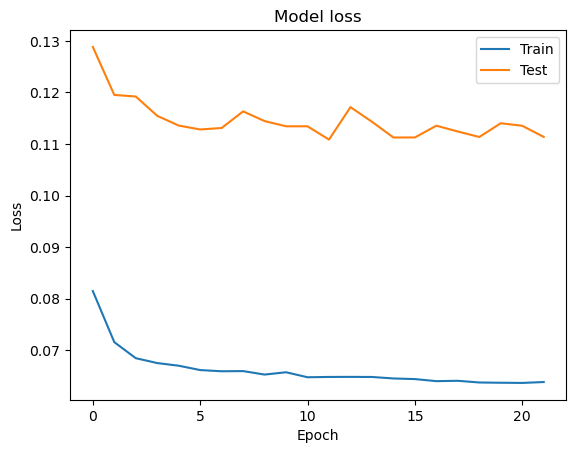

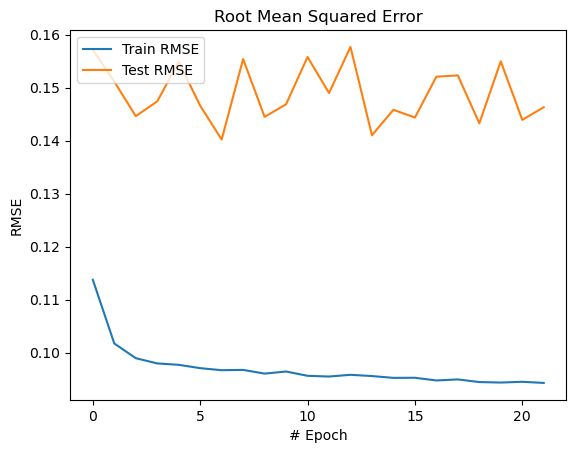

104/104 [==============================] - 0s 3ms/step - loss: 0.0666 - mse: 0.0099
Train RMSE: 0.0994879412484428
Test RMSE: 0.11325864730804118


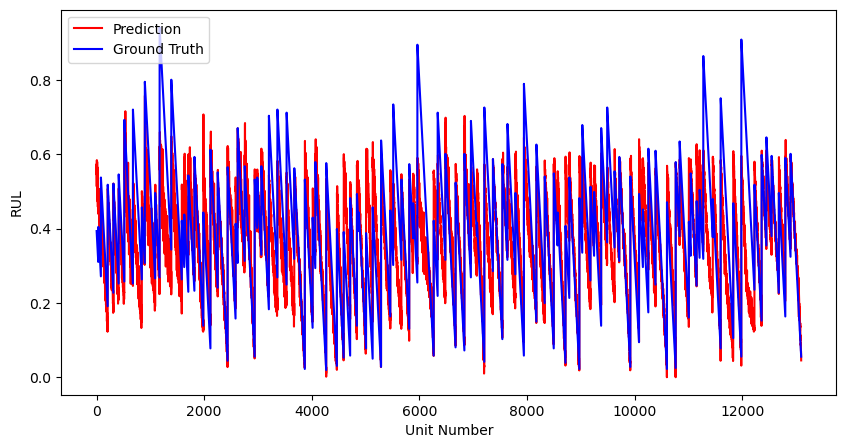

MAE:  0.08449847146637016
MSE:  0.012827523563027052
RMSE:  0.11325865778397276


In [88]:
my_bilstm(train_fd001, test_fd001)

Epoch 1/100
1512/1512 [==============================] - 17s 7ms/step - loss: 0.0940 - mse: 0.0159 - val_loss: 0.1164 - val_mse: 0.0213
Epoch 2/100
1512/1512 [==============================] - 8s 5ms/step - loss: 0.0869 - mse: 0.0139 - val_loss: 0.1146 - val_mse: 0.0217
Epoch 3/100
1512/1512 [==============================] - 9s 6ms/step - loss: 0.0847 - mse: 0.0133 - val_loss: 0.1190 - val_mse: 0.0237
Epoch 4/100
1512/1512 [==============================] - 8s 5ms/step - loss: 0.0816 - mse: 0.0125 - val_loss: 0.1046 - val_mse: 0.0182
Epoch 5/100
1512/1512 [==============================] - 9s 6ms/step - loss: 0.0780 - mse: 0.0116 - val_loss: 0.1127 - val_mse: 0.0218
Epoch 6/100
1512/1512 [==============================] - 8s 5ms/step - loss: 0.0765 - mse: 0.0113 - val_loss: 0.0968 - val_mse: 0.0165
Epoch 7/100
1512/1512 [==============================] - 9s 6ms/step - loss: 0.0756 - mse: 0.0110 - val_loss: 0.1110 - val_mse: 0.0209
Epoch 8/100
1512/1512 [==============================]

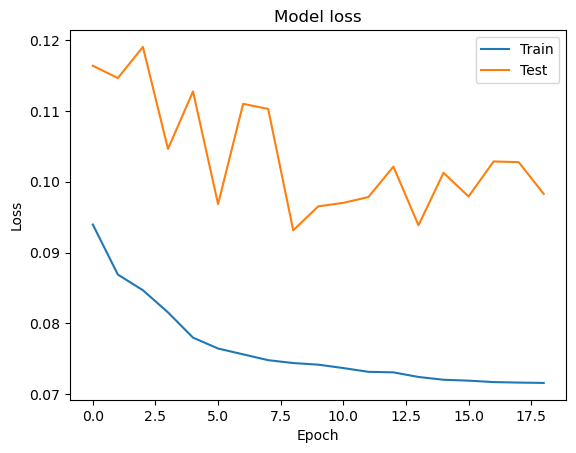

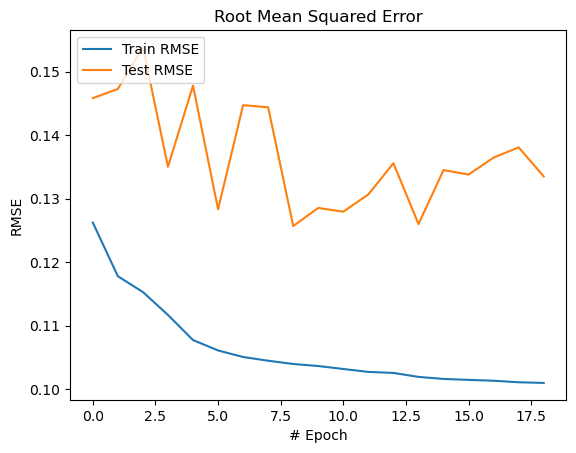

269/269 [==============================] - 3s 3ms/step - loss: 0.0715 - mse: 0.0104
Train RMSE: 0.10186389529811168
Test RMSE: 0.1251365169465766


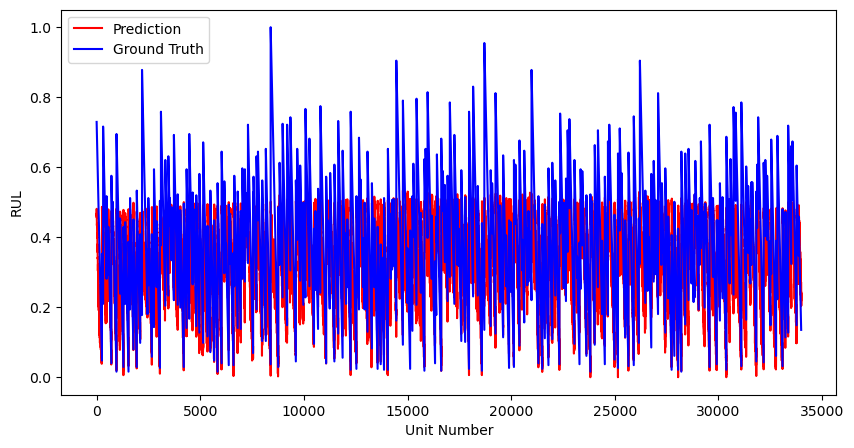

MAE:  0.0955193010494769
MSE:  0.01565914946414133
RMSE:  0.12513652330211725


In [90]:
my_bilstm(train_fd002, test_fd002)

Epoch 1/100
696/696 [==============================] - 15s 8ms/step - loss: 0.0872 - mse: 0.0156 - val_loss: 0.1202 - val_mse: 0.0340
Epoch 2/100
696/696 [==============================] - 4s 5ms/step - loss: 0.0775 - mse: 0.0119 - val_loss: 0.1162 - val_mse: 0.0335
Epoch 3/100
696/696 [==============================] - 4s 5ms/step - loss: 0.0746 - mse: 0.0113 - val_loss: 0.1204 - val_mse: 0.0363
Epoch 4/100
696/696 [==============================] - 4s 6ms/step - loss: 0.0730 - mse: 0.0109 - val_loss: 0.1056 - val_mse: 0.0285
Epoch 5/100
696/696 [==============================] - 4s 6ms/step - loss: 0.0706 - mse: 0.0105 - val_loss: 0.1006 - val_mse: 0.0277
Epoch 6/100
696/696 [==============================] - 4s 5ms/step - loss: 0.0696 - mse: 0.0104 - val_loss: 0.1101 - val_mse: 0.0333
Epoch 7/100
696/696 [==============================] - 4s 5ms/step - loss: 0.0688 - mse: 0.0103 - val_loss: 0.0966 - val_mse: 0.0262
Epoch 8/100
696/696 [==============================] - 4s 6ms/step -

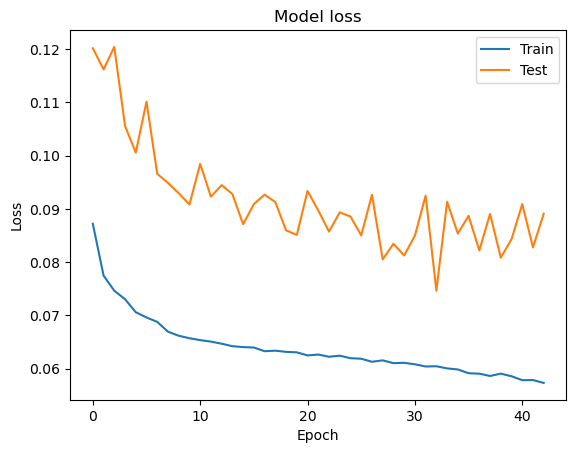

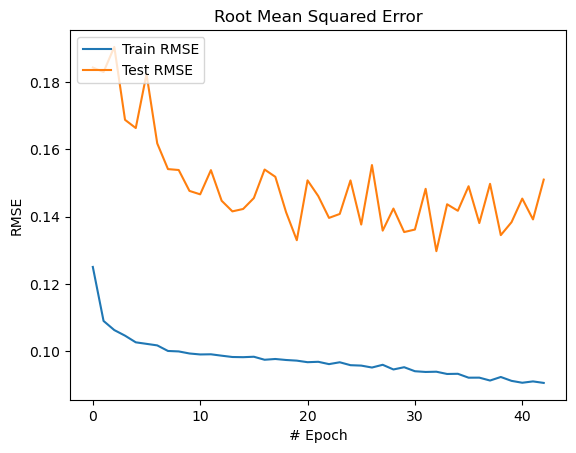

124/124 [==============================] - 0s 3ms/step - loss: 0.0582 - mse: 0.0094
Train RMSE: 0.09712794931854328
Test RMSE: 0.1432081048102725


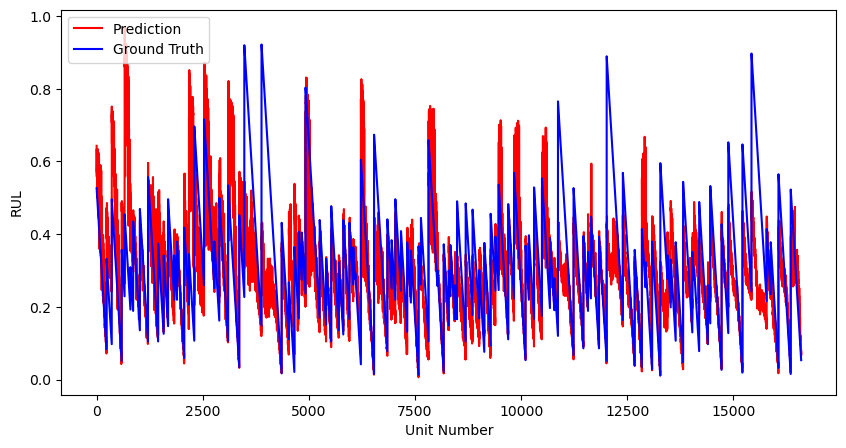

MAE:  0.09696202952797828
MSE:  0.020508555890182814
RMSE:  0.143208085980446


In [91]:
my_bilstm(train_fd003, test_fd003)

Epoch 1/100
1723/1723 [==============================] - 19s 7ms/step - loss: 0.0994 - mse: 0.0173 - val_loss: 0.0766 - val_mse: 0.0095
Epoch 2/100
1723/1723 [==============================] - 10s 6ms/step - loss: 0.0829 - mse: 0.0128 - val_loss: 0.0715 - val_mse: 0.0085
Epoch 3/100
1723/1723 [==============================] - 10s 6ms/step - loss: 0.0786 - mse: 0.0118 - val_loss: 0.0752 - val_mse: 0.0089
Epoch 4/100
1723/1723 [==============================] - 10s 6ms/step - loss: 0.0774 - mse: 0.0115 - val_loss: 0.0706 - val_mse: 0.0083
Epoch 5/100
1723/1723 [==============================] - 11s 6ms/step - loss: 0.0763 - mse: 0.0113 - val_loss: 0.0735 - val_mse: 0.0085
Epoch 6/100
1723/1723 [==============================] - 9s 5ms/step - loss: 0.0758 - mse: 0.0112 - val_loss: 0.0696 - val_mse: 0.0081
Epoch 7/100
1723/1723 [==============================] - 10s 6ms/step - loss: 0.0755 - mse: 0.0111 - val_loss: 0.0836 - val_mse: 0.0110
Epoch 8/100
1723/1723 [==========================

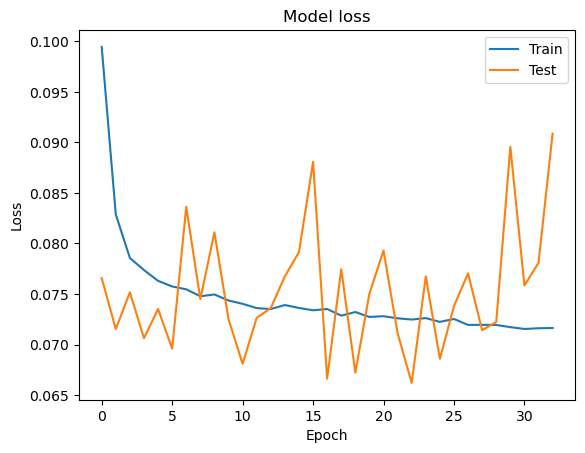

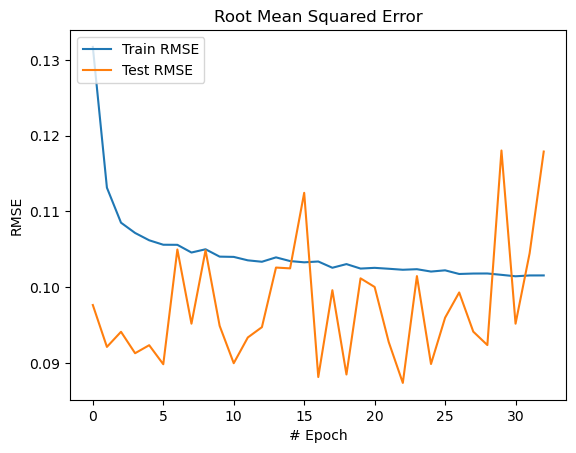

307/307 [==============================] - 1s 3ms/step - loss: 0.0767 - mse: 0.0104
Train RMSE: 0.10209906955103781
Test RMSE: 0.1338299459098579


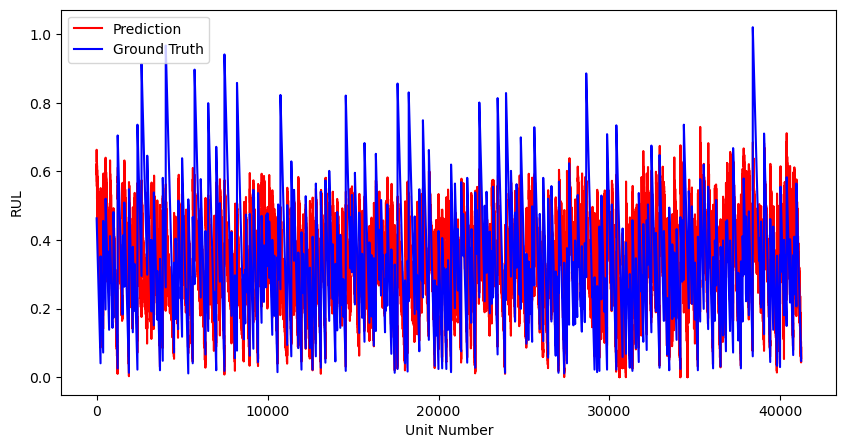

MAE:  0.10444908213219305
MSE:  0.0179104527068893
RMSE:  0.13382993950117927


In [92]:
my_bilstm(train_fd004, test_fd004)

# **BiLSTM and Feature Selection**

In [15]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

def my_bilstm2(train, test, wich):
    
    train_selected, test_selected = drop_columns(train, test, wich)

    # Normaliser les données
    scaler = MinMaxScaler()

    train_scaled = scaler.fit_transform(train_selected)
    test_scaled = scaler.transform(test_selected)

    # Préparer les données pour le modèle LSTM
    train_X = train_scaled[:,:-1]
    train_y = train_scaled[:,-1]

    test_X = test_scaled[:,:-1]
    test_y = test_scaled[:,-1]

    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    # Créer le modèle BiLSTM
    model = Sequential()
    model.add(Bidirectional(LSTM(units=100, return_sequences=True), input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(units=100, return_sequences=False)))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.add(Activation("relu"))

    # Compiler le modèle avec une optimisation
    model.compile(loss='mae', optimizer=Adam(), metrics=['mse'])

    # Entraîner le modèle
    history = model.fit(train_X, train_y, epochs=100, batch_size=32, validation_split=0.1, verbose=1,
          callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

    # Afficher l'erreur d'entraînement et de validation sur une courbe
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Test')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    # Calculer et afficher RMSE
    rmse_train = np.sqrt(history.history['mse'])
    rmse_test = np.sqrt(history.history['val_mse'])
    plt.plot(rmse_train, label='Train RMSE')
    plt.plot(rmse_test, label='Test RMSE')
    plt.title('Root Mean Squared Error')
    plt.ylabel('RMSE')
    plt.xlabel('# Epoch')
    plt.legend(loc='upper left')
    plt.show()

    scores = model.evaluate(train_X, train_y, verbose=1, batch_size=200)
    print('Train RMSE: {}'.format(np.sqrt(scores[1])))
    
    scores_test = model.evaluate(test_X, test_y, verbose=200)
    print('Test RMSE: {}'.format(np.sqrt(scores_test[1])))
    
    y_pred_test = model.predict(test_X, verbose=200)
    plt.figure(figsize=(10,5))
    plt.plot(y_pred_test, color='red', label='Prediction')
    plt.plot(test_y, color='blue', label='Ground Truth')
    plt.ylabel("RUL")
    plt.xlabel("Unit Number")
    plt.legend(loc='upper left')
    plt.show()

    # calculer le MAE et RMSE
    mae = mean_absolute_error(test_y, y_pred_test)
    mse = mean_squared_error(test_y, y_pred_test)
    rmse = np.sqrt(mean_squared_error(test_y, y_pred_test))
    print('MAE: ', mae)
    print('MSE: ', mse)
    print('RMSE: ', rmse)


Epoch 1/100
581/581 [==============================] - 12s 8ms/step - loss: 0.0824 - mse: 0.0131 - val_loss: 0.1315 - val_mse: 0.0258
Epoch 2/100
581/581 [==============================] - 3s 6ms/step - loss: 0.0743 - mse: 0.0107 - val_loss: 0.1248 - val_mse: 0.0244
Epoch 3/100
581/581 [==============================] - 3s 6ms/step - loss: 0.0705 - mse: 0.0100 - val_loss: 0.1190 - val_mse: 0.0228
Epoch 4/100
581/581 [==============================] - 3s 5ms/step - loss: 0.0692 - mse: 0.0097 - val_loss: 0.1160 - val_mse: 0.0220
Epoch 5/100
581/581 [==============================] - 3s 5ms/step - loss: 0.0693 - mse: 0.0098 - val_loss: 0.1205 - val_mse: 0.0215
Epoch 6/100
581/581 [==============================] - 3s 5ms/step - loss: 0.0689 - mse: 0.0097 - val_loss: 0.1182 - val_mse: 0.0235
Epoch 7/100
581/581 [==============================] - 3s 6ms/step - loss: 0.0681 - mse: 0.0096 - val_loss: 0.1169 - val_mse: 0.0247
Epoch 8/100
581/581 [==============================] - 4s 6ms/step -

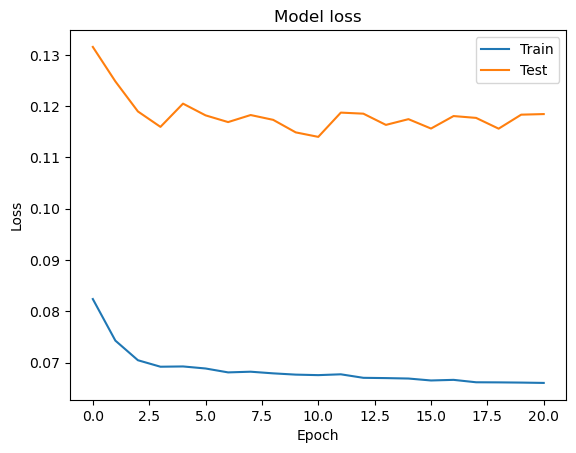

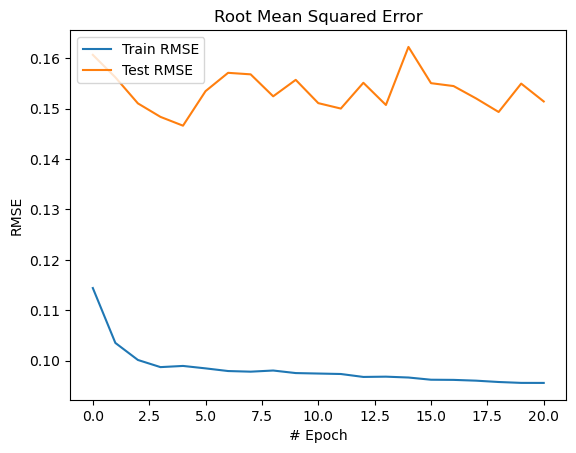

104/104 [==============================] - 0s 3ms/step - loss: 0.0699 - mse: 0.0102
Train RMSE: 0.10095545568434146
Test RMSE: 0.11575155661851433


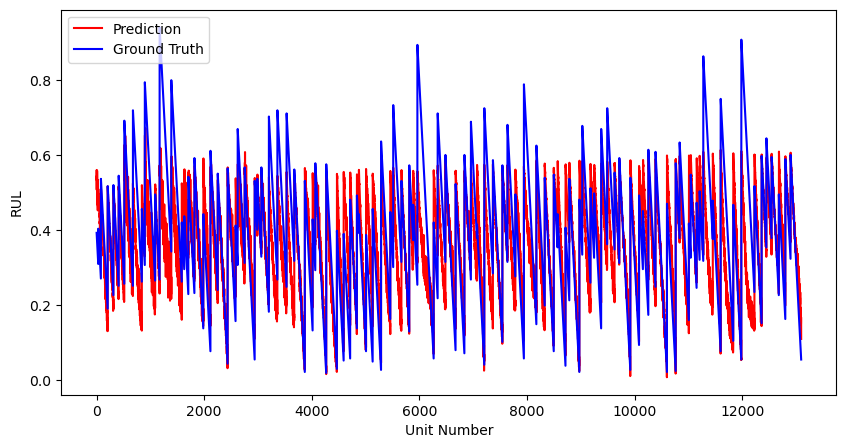

MAE:  0.08647431908888518
MSE:  0.013398420234034121
RMSE:  0.11575154527708958


In [17]:
my_bilstm2(train_fd001, test_fd001, 1)

Epoch 1/100
1512/1512 [==============================] - 18s 7ms/step - loss: 0.0943 - mse: 0.0161 - val_loss: 0.1232 - val_mse: 0.0248
Epoch 2/100
1512/1512 [==============================] - 8s 5ms/step - loss: 0.0870 - mse: 0.0139 - val_loss: 0.1161 - val_mse: 0.0225
Epoch 3/100
1512/1512 [==============================] - 9s 6ms/step - loss: 0.0855 - mse: 0.0135 - val_loss: 0.1072 - val_mse: 0.0180
Epoch 4/100
1512/1512 [==============================] - 8s 5ms/step - loss: 0.0824 - mse: 0.0127 - val_loss: 0.1178 - val_mse: 0.0231
Epoch 5/100
1512/1512 [==============================] - 9s 6ms/step - loss: 0.0788 - mse: 0.0118 - val_loss: 0.1130 - val_mse: 0.0221
Epoch 6/100
1512/1512 [==============================] - 8s 6ms/step - loss: 0.0771 - mse: 0.0114 - val_loss: 0.1194 - val_mse: 0.0245
Epoch 7/100
1512/1512 [==============================] - 9s 6ms/step - loss: 0.0757 - mse: 0.0111 - val_loss: 0.1057 - val_mse: 0.0186
Epoch 8/100
1512/1512 [==============================]

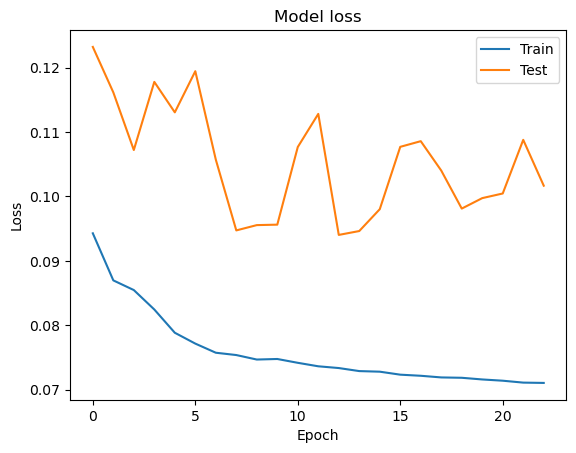

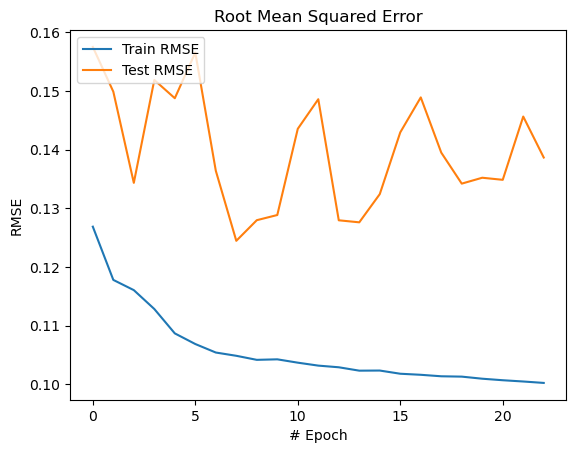

269/269 [==============================] - 3s 3ms/step - loss: 0.0713 - mse: 0.0103
Train RMSE: 0.10144922468524634
Test RMSE: 0.12413646773860884


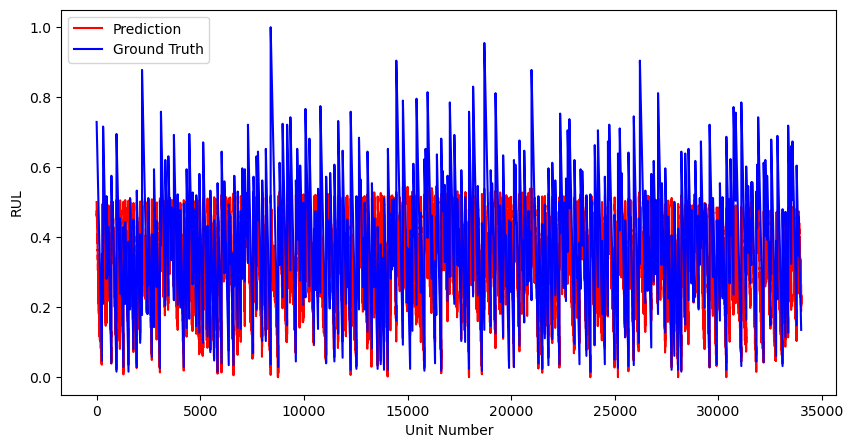

MAE:  0.09492345547326976
MSE:  0.015409856415835005
RMSE:  0.1241364427387663


In [18]:
my_bilstm2(train_fd002, test_fd002, 2)

Epoch 1/100
696/696 [==============================] - 13s 8ms/step - loss: 0.0900 - mse: 0.0178 - val_loss: 0.1116 - val_mse: 0.0301
Epoch 2/100
696/696 [==============================] - 4s 5ms/step - loss: 0.0777 - mse: 0.0121 - val_loss: 0.1158 - val_mse: 0.0342
Epoch 3/100
696/696 [==============================] - 4s 5ms/step - loss: 0.0730 - mse: 0.0108 - val_loss: 0.1064 - val_mse: 0.0308
Epoch 4/100
696/696 [==============================] - 4s 6ms/step - loss: 0.0719 - mse: 0.0107 - val_loss: 0.1117 - val_mse: 0.0341
Epoch 5/100
696/696 [==============================] - 4s 6ms/step - loss: 0.0704 - mse: 0.0104 - val_loss: 0.1004 - val_mse: 0.0278
Epoch 6/100
696/696 [==============================] - 4s 5ms/step - loss: 0.0696 - mse: 0.0104 - val_loss: 0.1008 - val_mse: 0.0258
Epoch 7/100
696/696 [==============================] - 4s 5ms/step - loss: 0.0691 - mse: 0.0104 - val_loss: 0.1008 - val_mse: 0.0272
Epoch 8/100
696/696 [==============================] - 4s 6ms/step -

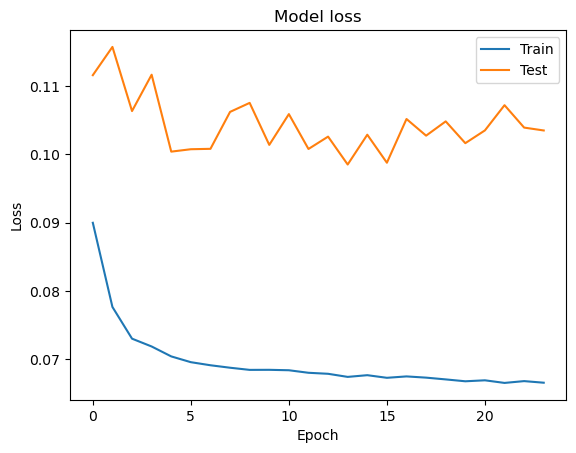

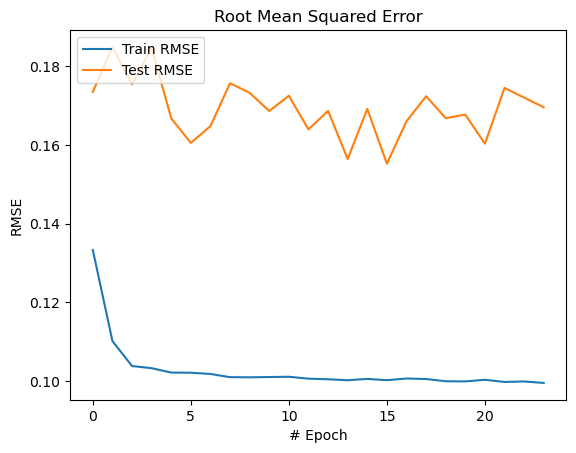

124/124 [==============================] - 0s 3ms/step - loss: 0.0699 - mse: 0.0118
Train RMSE: 0.10852028897137884
Test RMSE: 0.1351200639650697


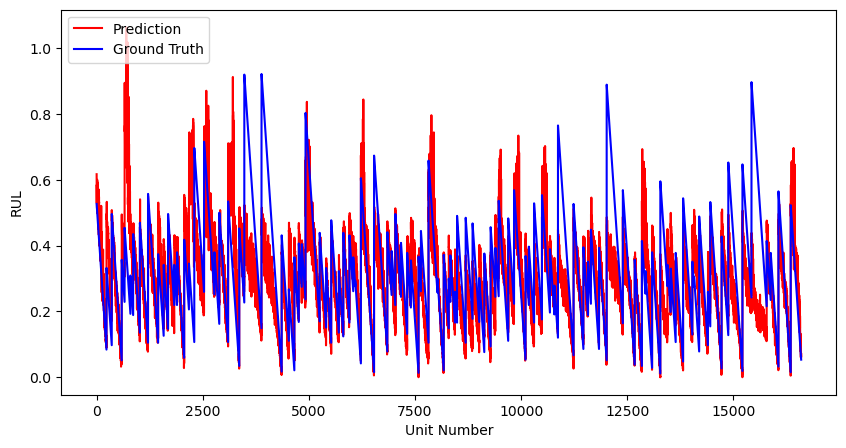

MAE:  0.09152766263436453
MSE:  0.01825742896932347
RMSE:  0.1351200539125243


In [19]:
my_bilstm2(train_fd003, test_fd003, 3)

Epoch 1/100
1723/1723 [==============================] - 18s 7ms/step - loss: 0.0984 - mse: 0.0170 - val_loss: 0.0814 - val_mse: 0.0099
Epoch 2/100
1723/1723 [==============================] - 10s 6ms/step - loss: 0.0834 - mse: 0.0130 - val_loss: 0.0718 - val_mse: 0.0091
Epoch 3/100
1723/1723 [==============================] - 9s 6ms/step - loss: 0.0807 - mse: 0.0124 - val_loss: 0.0791 - val_mse: 0.0093
Epoch 4/100
1723/1723 [==============================] - 10s 6ms/step - loss: 0.0790 - mse: 0.0119 - val_loss: 0.0720 - val_mse: 0.0084
Epoch 5/100
1723/1723 [==============================] - 9s 5ms/step - loss: 0.0783 - mse: 0.0118 - val_loss: 0.0771 - val_mse: 0.0091
Epoch 6/100
1723/1723 [==============================] - 10s 6ms/step - loss: 0.0775 - mse: 0.0115 - val_loss: 0.0725 - val_mse: 0.0085
Epoch 7/100
1723/1723 [==============================] - 10s 6ms/step - loss: 0.0768 - mse: 0.0114 - val_loss: 0.0770 - val_mse: 0.0097
Epoch 8/100
1723/1723 [===========================

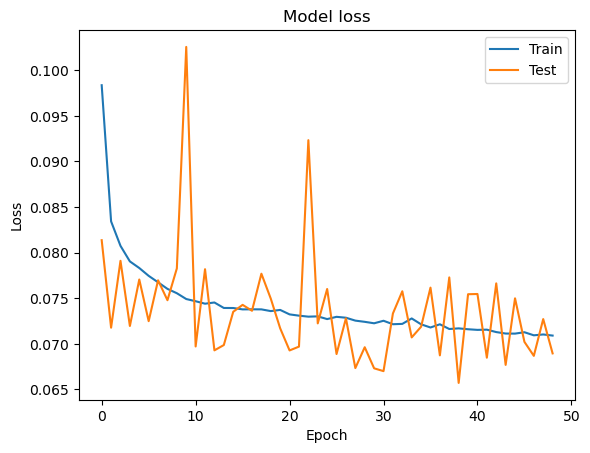

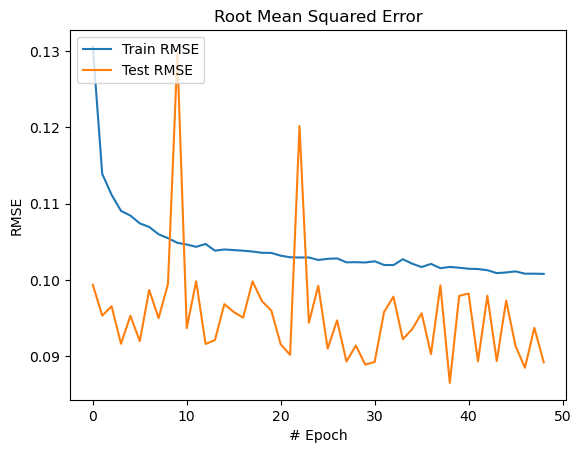

307/307 [==============================] - 1s 3ms/step - loss: 0.0682 - mse: 0.0095
Train RMSE: 0.09745027755203083
Test RMSE: 0.14021196239384015


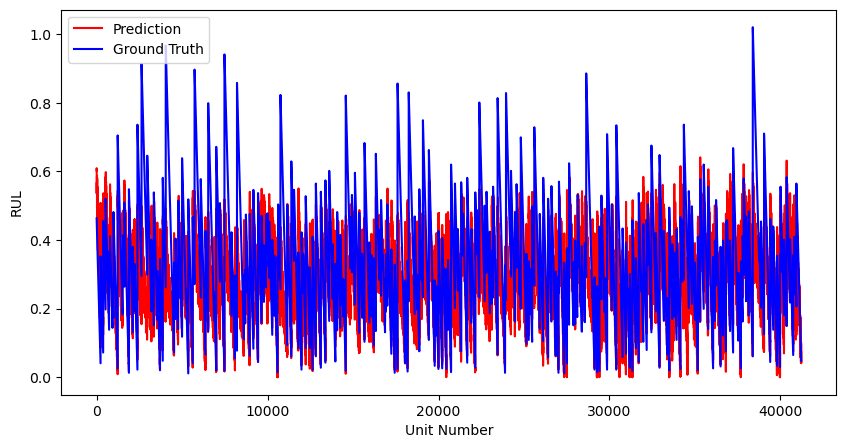

MAE:  0.10262867935975983
MSE:  0.019659393168887613
RMSE:  0.14021195800960634


In [20]:
my_bilstm2(train_fd004, test_fd004, 4)